In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Rmatrix_train_csv = pd.read_csv("https://raw.githubusercontent.com/hyepark/IEEEAccess2023/main/Rating_Matrix_100k_Train.csv", index_col=0)
Rmatrix_csv       = pd.read_csv("https://raw.githubusercontent.com/hyepark/IEEEAccess2023/main/Rating_Matrix_100k_All.csv", index_col=0)
Rmatrix_train_csv = Rmatrix_train_csv.replace(np.nan, 0)
Rmatrix_csv       = Rmatrix_csv.replace(np.nan, 0)

Rmatrix_train = np.array(Rmatrix_train_csv)
Rmatrix       = np.array(Rmatrix_csv)

Bmatrix_train = np.where(Rmatrix_train > 0, 1, 0)
Bmatrix = np.where(Rmatrix > 0, 1, 0)

num_user  = len(Rmatrix_csv.index)
num_movie = len(Rmatrix_csv.columns)

In [2]:
print("Users:", num_user)
print("Movies:", num_movie)
print("Ratings:", np.sum(Bmatrix))
print("Density (Training Dataset):", np.sum(Bmatrix_train)/(num_user*num_movie))
print("Density (All Dataset):", np.sum(Bmatrix)/(num_user*num_movie))

Users: 943
Movies: 1650
Ratings: 99968
Density (Training Dataset): 0.051415533918185034
Density (All Dataset): 0.06424885118416401


In [3]:
class AE(nn.Module):
    def __init__(self, ):
        super(AE, self).__init__()
        self.fc1 = nn.Linear(num_movie, 16)
        self.fc2 = nn.Linear(16, num_movie)
        #self.activation = nn.ReLU()
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        y = self.fc2(x)
        return x, y

In [4]:
ae = AE(); ae.load_state_dict(torch.load('ae_100k.pt'))
ae_cat = AE(); ae_cat.load_state_dict(torch.load('ae_cat_100k.pt'))
ae_cat2 = AE(); ae_cat2.load_state_dict(torch.load('ae_cat2_100k.pt'))
ae_main = AE(); ae_main.load_state_dict(torch.load('ae_main_100k.pt'))

<All keys matched successfully>

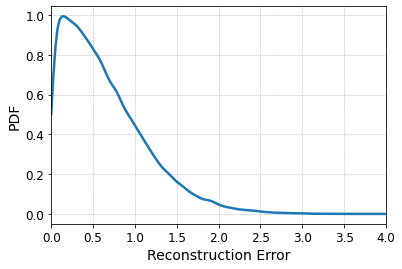

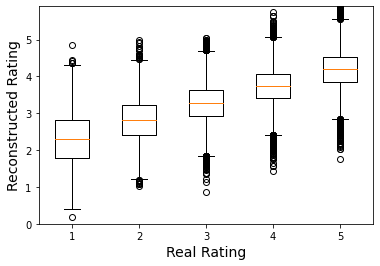

In [5]:
training_in = Rmatrix_train/5
training_set = torch.FloatTensor(Rmatrix_train)/5

for i in range(num_user):
    input = Variable(training_set[i]).unsqueeze(0)
    output = ae(input)[1]
    output[input == 0] = 0

    if i == 0: training_out = output.detach().numpy()
    else: training_out = np.append(training_out, output.detach().numpy(), axis=0)

train_loss_mat = 5*np.abs(training_in - training_out)
train_loss_list  = []; train_loss_list1 = []; train_loss_list2 = []
train_loss_list3 = []; train_loss_list4 = []; train_loss_list5 = []
for i in range(len(train_loss_mat)):
    for j in range(len(train_loss_mat[0])):
        if train_loss_mat[i][j] != 0:
            train_loss_list += [train_loss_mat[i][j]]
        if round(5*training_in[i][j]) == 1: train_loss_list1 += [5*training_out[i][j]]
        if round(5*training_in[i][j]) == 2: train_loss_list2 += [5*training_out[i][j]]
        if round(5*training_in[i][j]) == 3: train_loss_list3 += [5*training_out[i][j]]
        if round(5*training_in[i][j]) == 4: train_loss_list4 += [5*training_out[i][j]]
        if round(5*training_in[i][j]) == 5: train_loss_list5 += [5*training_out[i][j]]

xs = np.linspace(0.0, 5.0, 200)
pdf_pred = gaussian_kde(train_loss_list)
fig_pdf_train = plt.figure()
plt.plot(xs, pdf_pred(xs), linewidth=2.5)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Reconstruction Error", fontsize=14)
plt.ylabel("PDF", fontsize=14)
plt.xlim([0,4])
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

fig_box_train, ax = plt.subplots()
ax.boxplot(np.array([train_loss_list1, train_loss_list2, train_loss_list3, train_loss_list4, train_loss_list5], dtype=object))
ax.set_xlabel("Real Rating", fontsize=14)
ax.set_ylabel("Reconstructed Rating", fontsize=14)
plt.ylim([0,5.9])
plt.show()

In [6]:
Rmatrix_train_pre = Rmatrix_train.copy()
Rmatrix_pre = Rmatrix.copy()

Cat_user  = np.zeros((num_user, num_movie))
Cat_movie = np.zeros((num_user, num_movie))

for i in range(num_user):
    Weak_user    = list(Rmatrix_train[i]).count(1) >= list(Rmatrix_train[i]).count(2) + list(Rmatrix_train[i]).count(3) + list(Rmatrix_train[i]).count(4) + list(Rmatrix_train[i]).count(5)
    Average_user = list(Rmatrix_train[i]).count(2) + list(Rmatrix_train[i]).count(3) >= list(Rmatrix_train[i]).count(1) + list(Rmatrix_train[i]).count(4) + list(Rmatrix_train[i]).count(5)
    Strong_user  = list(Rmatrix_train[i]).count(4) + list(Rmatrix_train[i]).count(5) >= list(Rmatrix_train[i]).count(1) + list(Rmatrix_train[i]).count(2) + list(Rmatrix_train[i]).count(3)
    if Weak_user:    Cat_user[i] = np.array([1 for _ in range(num_movie)])
    if Average_user: Cat_user[i] = np.array([10 for _ in range(num_movie)])
    if Strong_user:  Cat_user[i] = np.array([100 for _ in range(num_movie)])

for j in range(num_movie):
    Weak_movie    = list(Rmatrix_train[:,j]).count(1) >= list(Rmatrix_train[:,j]).count(2) + list(Rmatrix_train[:,j]).count(3) + list(Rmatrix_train[:,j]).count(4) + list(Rmatrix_train[:,j]).count(5)
    Average_movie = list(Rmatrix_train[:,j]).count(2) + list(Rmatrix_train[:,j]).count(3) >= list(Rmatrix_train[:,j]).count(1) + list(Rmatrix_train[:,j]).count(4) + list(Rmatrix_train[:,j]).count(5)
    Strong_movie  = list(Rmatrix_train[:,j]).count(4) + list(Rmatrix_train[:,j]).count(5) >= list(Rmatrix_train[:,j]).count(1) + list(Rmatrix_train[:,j]).count(2) + list(Rmatrix_train[:,j]).count(3)
    if Weak_movie:    Cat_movie[:,j] = np.array([1 for _ in range(num_user)])
    if Average_movie: Cat_movie[:,j] = np.array([10 for _ in range(num_user)])
    if Strong_movie:  Cat_movie[:,j] = np.array([100 for _ in range(num_user)])

Cat_rating = Cat_user+Cat_movie
for i in range(num_user):
    for j in range(num_movie):
        if Cat_rating[i][j] == 2 and Rmatrix_train[i][j] >= 2:
            Rmatrix_train_pre[i][j] = 0; Rmatrix_pre[i][j] = 0
        if Cat_rating[i][j] == 20 and 0 < Rmatrix_train[i][j] < 2:
            Rmatrix_train_pre[i][j] = 0; Rmatrix_pre[i][j] = 0
        if Cat_rating[i][j] == 20 and Rmatrix_train[i][j] >= 4:
            Rmatrix_train_pre[i][j] = 0; Rmatrix_pre[i][j] = 0
        if Cat_rating[i][j] == 200 and 0 < Rmatrix_train[i][j] < 4:
            Rmatrix_train_pre[i][j] = 0; Rmatrix_pre[i][j] = 0

In [7]:
Rmatrix_train_pre2 = Rmatrix_train.copy()
Rmatrix_pre2 = Rmatrix.copy()

for i in range(num_user):
    for j in range(num_movie):
        if Cat_rating[i][j] == 2 and Rmatrix_train[i][j] >= 2:
            Rmatrix_train_pre2[i][j] = 1; Rmatrix_pre2[i][j] = 1
        if Cat_rating[i][j] == 20 and 0 < Rmatrix_train[i][j] < 2:
            Rmatrix_train_pre2[i][j] = 2.5; Rmatrix_pre2[i][j] = 2.5
        if Cat_rating[i][j] == 20 and Rmatrix_train[i][j] >= 4:
            Rmatrix_train_pre2[i][j] = 2.5; Rmatrix_pre2[i][j] = 2.5
        if Cat_rating[i][j] == 200 and 0 < Rmatrix_train[i][j] < 4:
            Rmatrix_train_pre2[i][j] = 4.5; Rmatrix_pre2[i][j] = 4.5

In [8]:
Rmatrix_train_new = Rmatrix_train_pre.copy()
Rmatrix_new = Rmatrix_pre.copy()

for i in range(len(train_loss_mat)):
    for j in range(len(train_loss_mat[0])):
        if train_loss_mat[i][j] > 1.5:
            Rmatrix_train_new[i][j] = 0
            Rmatrix_new[i][j] = 0

training_set_pre = torch.FloatTensor(Rmatrix_train_pre)/5
training_set_pre2 = torch.FloatTensor(Rmatrix_train_pre2)/5
training_set_new = torch.FloatTensor(Rmatrix_train_new)/5

In [9]:
user_coverage1 = num_user - np.sum(Rmatrix_train, axis=0).tolist().count(0)
user_coverage2 = num_user - np.sum(Rmatrix_train_pre, axis=0).tolist().count(0)
user_coverage3 = num_user - np.sum(Rmatrix_train_new, axis=0).tolist().count(0)
item_coverage1 = num_movie - np.sum(Rmatrix_train, axis=1).tolist().count(0)
item_coverage2 = num_movie - np.sum(Rmatrix_train_pre, axis=1).tolist().count(0)
item_coverage3 = num_movie - np.sum(Rmatrix_train_new, axis=1).tolist().count(0)

coverage1 = (user_coverage1*item_coverage1)/(num_user*num_movie)
coverage2 = (user_coverage2*item_coverage2)/(num_user*num_movie)
coverage3 = (user_coverage3*item_coverage3)/(num_user*num_movie)

print("Coverage1:", coverage1)
print("Coverage2:", coverage2)
print("Coverage3:", coverage3)

Coverage1: 1.0
Coverage2: 1.0
Coverage3: 1.0


In [10]:
test_in = Rmatrix/5
test_set = torch.FloatTensor(Rmatrix)/5

for i in range(num_user):
    input = Variable(training_set[i]).unsqueeze(0)
    target = Variable(test_set[i]).unsqueeze(0)
    output = ae(input)[1]
    output[target == input] = input[target == input]

    if i == 0: test_out = output.detach().numpy()
    else: test_out = np.append(test_out, output.detach().numpy(), axis=0)

test_loss_mat = np.abs(test_in - test_out)
test_list = {}; test_list['user'] = []; test_list['item'] = []; test_list['real'] = []; test_list['pred'] = []; test_list['loss'] = []
for i in range(len(test_loss_mat)):
    for j in range(len(test_loss_mat[0])):
        if test_loss_mat[i][j] > 1e-7:
            test_list['user'] += [i]
            test_list['item'] += [j]
            test_list['real'] += [5*test_in[i][j]]
            test_list['pred'] += [5*test_out[i][j]]
            test_list['loss'] += [5*test_loss_mat[i][j]]
test_list = pd.DataFrame(test_list)



test_in_pre = Rmatrix_pre/5
test_set_pre = torch.FloatTensor(Rmatrix_pre)/5

for i in range(num_user):
    input = Variable(training_set_pre[i]).unsqueeze(0)
    target = Variable(test_set_pre[i]).unsqueeze(0)
    output = ae_cat(input)[1]
    output[target == input] = input[target == input]

    if i == 0: test_out_pre = output.detach().numpy()
    else: test_out_pre = np.append(test_out_pre, output.detach().numpy(), axis=0)

test_loss_mat2 = np.abs(test_in_pre - test_out_pre)
test_list2 = {}; test_list2['user'] = []; test_list2['item'] = []; test_list2['real'] = []; test_list2['pred'] = []; test_list2['loss'] = []
for i in range(len(test_loss_mat2)):
    for j in range(len(test_loss_mat2[0])):
        if test_loss_mat2[i][j] > 1e-7:
            test_list2['user'] += [i]
            test_list2['item'] += [j]
            test_list2['real'] += [5*test_in_pre[i][j]]
            test_list2['pred'] += [5*test_out_pre[i][j]]
            test_list2['loss'] += [5*test_loss_mat2[i][j]]
test_list2 = pd.DataFrame(test_list2)



test_in_pre2 = Rmatrix_pre2/5
test_set_pre2 = torch.FloatTensor(Rmatrix_pre2)/5

for i in range(num_user):
    input = Variable(training_set_pre2[i]).unsqueeze(0)
    target = Variable(test_set_pre2[i]).unsqueeze(0)
    output = ae_cat2(input)[1]
    output[target == input] = input[target == input]

    if i == 0: test_out_pre2 = output.detach().numpy()
    else: test_out_pre2 = np.append(test_out_pre2, output.detach().numpy(), axis=0)

test_loss_mat22 = np.abs(test_in_pre2 - test_out_pre2)
test_list22 = {}; test_list22['user'] = []; test_list22['item'] = []; test_list22['real'] = []; test_list22['pred'] = []; test_list22['loss'] = []
for i in range(len(test_loss_mat22)):
    for j in range(len(test_loss_mat22[0])):
        if test_loss_mat22[i][j] > 1e-7:
            test_list22['user'] += [i]
            test_list22['item'] += [j]
            test_list22['real'] += [5*test_in_pre2[i][j]]
            test_list22['pred'] += [5*test_out_pre2[i][j]]
            test_list22['loss'] += [5*test_loss_mat22[i][j]]
test_list22 = pd.DataFrame(test_list22)



test_in_new = Rmatrix_new/5
test_set_new = torch.FloatTensor(Rmatrix_new)/5

for i in range(num_user):
    input = Variable(training_set_new[i]).unsqueeze(0)
    target = Variable(test_set_new[i]).unsqueeze(0)
    output = ae_main(input)[1]
    output[target == input] = input[target == input]

    if i == 0: test_out_new = output.detach().numpy()
    else: test_out_new = np.append(test_out_new, output.detach().numpy(), axis=0)

test_loss_mat3 = np.abs(test_in_new - test_out_new)
test_list3 = {}; test_list3['user'] = []; test_list3['item'] = []; test_list3['real'] = []; test_list3['pred'] = []; test_list3['loss'] = []
for i in range(len(test_loss_mat3)):
    for j in range(len(test_loss_mat3[0])):
        if test_loss_mat3[i][j] > 1e-7:
            test_list3['user'] += [i]
            test_list3['item'] += [j]
            test_list3['real'] += [5*test_in_new[i][j]]
            test_list3['pred'] += [5*test_out_new[i][j]]
            test_list3['loss'] += [5*test_loss_mat3[i][j]]
test_list3 = pd.DataFrame(test_list3)

ratio low rank: 0.8
test RMSE1: 0.6342, test MAE1: 0.5369
test RMSE2: 0.6185, test MAE2: 0.5216
test RMSE22: 0.6289, test MAE22: 0.5295
test RMSE3: 0.6108, test MAE3: 0.5147
----------------------------------------
ratio low rank: 0.85
test RMSE1: 0.6902, test MAE1: 0.5811
test RMSE2: 0.6752, test MAE2: 0.566
test RMSE22: 0.6858, test MAE22: 0.5742
test RMSE3: 0.6687, test MAE3: 0.5596
----------------------------------------
ratio low rank: 0.9
test RMSE1: 0.755, test MAE1: 0.6305
test RMSE2: 0.7406, test MAE2: 0.6154
test RMSE22: 0.7516, test MAE22: 0.6241
test RMSE3: 0.7361, test MAE3: 0.6099
----------------------------------------
ratio low rank: 0.95
test RMSE1: 0.833, test MAE1: 0.6872
test RMSE2: 0.8236, test MAE2: 0.6742
test RMSE22: 0.8356, test MAE22: 0.6837
test RMSE3: 0.8217, test MAE3: 0.6699
----------------------------------------
ratio low rank: 1
test RMSE1: 0.9591, test MAE1: 0.7656
test RMSE2: 0.9707, test MAE2: 0.7608
test RMSE22: 0.9825, test MAE22: 0.7707
test RM

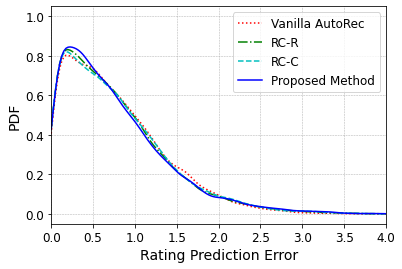

In [11]:
def RMSE(x):
    y = 0
    for i in range(len(x)):
        y += x[i]*x[i]
    y = np.sqrt(y/len(x))
    return y

test_list_sort = test_list.sort_values(by=["loss"], ascending=[True])
test_list_sort2 = test_list2.sort_values(by=["loss"], ascending=[True])
test_list_sort22 = test_list22.sort_values(by=["loss"], ascending=[True])
test_list_sort3 = test_list3.sort_values(by=["loss"], ascending=[True])

ratio_low_rank = [0.8, 0.85, 0.9, 0.95, 1]
RMSE_list1 = []; RMSE_list2 = []; RMSE_list22 = []; RMSE_list3 = []
MAE_list1 = []; MAE_list2 = []; MAE_list22 = []; MAE_list3 = []
for r in ratio_low_rank:
    print('ratio low rank: '+str(r))
    num_high_rank = int(len(test_list_sort['loss'])*(1-r)); num_low_rank = int(len(test_list_sort['loss'])*r)

    RMSE_list1 += [RMSE(np.array(test_list_sort['loss'])[:num_low_rank])]
    MAE_list1 += [np.mean(np.array(test_list_sort['loss'])[:num_low_rank])]
    print('test RMSE1: '+str(round(RMSE_list1[-1],4))+', test MAE1: '+str(round(MAE_list1[-1],4)))
    
    RMSE_list2 += [RMSE(np.array(test_list_sort2['loss'])[:num_low_rank])]
    MAE_list2 += [np.mean(np.array(test_list_sort2['loss'])[:num_low_rank])]
    print('test RMSE2: '+str(round(RMSE_list2[-1],4))+', test MAE2: '+str(round(MAE_list2[-1],4)))

    RMSE_list22 += [RMSE(np.array(test_list_sort22['loss'])[:num_low_rank])]
    MAE_list22 += [np.mean(np.array(test_list_sort22['loss'])[:num_low_rank])]
    print('test RMSE22: '+str(round(RMSE_list22[-1],4))+', test MAE22: '+str(round(MAE_list22[-1],4)))
    
    RMSE_list3 += [RMSE(np.array(test_list_sort3['loss'])[:num_low_rank])]
    MAE_list3 += [np.mean(np.array(test_list_sort3['loss'])[:num_low_rank])]
    print('test RMSE3: '+str(round(RMSE_list3[-1],4))+', test MAE3: '+str(round(MAE_list3[-1],4)))
    print('----------------------------------------')

xs = np.linspace(0.0, 5.0, 200)
pdf_pred = gaussian_kde(test_list_sort['loss'])
pdf_pred2 = gaussian_kde(test_list_sort2['loss'])
pdf_pred22 = gaussian_kde(test_list_sort22['loss'])
pdf_pred3 = gaussian_kde(test_list_sort3['loss'])
fig_pdf = plt.figure()
plt.plot(xs, pdf_pred(xs), "r:", linewidth=1.5, label="Vanilla AutoRec")
plt.plot(xs, pdf_pred2(xs), "g-.", linewidth=1.5, label="RC-R")
plt.plot(xs, pdf_pred22(xs), "c--", linewidth=1.5, label="RC-C")
plt.plot(xs, pdf_pred3(xs), "b", linewidth=1.5, label="Proposed Method")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Rating Prediction Error", fontsize=14)
plt.ylabel("PDF", fontsize=14)
plt.xlim([0,4])
plt.ylim([-0.05,1.05])
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(fontsize=12, loc=1)
plt.show()

In [12]:
def BIN(real,pred):
    tp_num = 0; fp_num = 0; fn_num = 0; tn_num = 0
    for i in range(len(real)):
        if real[i] == 1 and pred[i] == 1:
            tp_num += 1
        if real[i] == 0 and pred[i] == 1:
            fp_num += 1
        if real[i] == 1 and pred[i] == 0:
            fn_num += 1
        if real[i] == 0 and pred[i] == 0:
            tn_num += 1
    return tp_num, fp_num, fn_num, tn_num

test_list_bin = test_list.copy()
test_list_bin2 = test_list2.copy()
test_list_bin22 = test_list22.copy()
test_list_bin3 = test_list3.copy()

threshold_rate = 3.5
test_list_bin.loc[test_list_bin['real'] < threshold_rate, 'real'] = 0
test_list_bin.loc[test_list_bin['real'] > threshold_rate, 'real'] = 1
test_list_bin.loc[test_list_bin['pred'] < threshold_rate, 'pred'] = 0
test_list_bin.loc[test_list_bin['pred'] > threshold_rate, 'pred'] = 1
test_list_bin['loss'] = np.abs(np.array(test_list_bin['real']) - np.array(test_list_bin['pred'])).tolist()
test_list_bin2.loc[test_list_bin2['real'] < threshold_rate, 'real'] = 0
test_list_bin2.loc[test_list_bin2['real'] > threshold_rate, 'real'] = 1
test_list_bin2.loc[test_list_bin2['pred'] < threshold_rate, 'pred'] = 0
test_list_bin2.loc[test_list_bin2['pred'] > threshold_rate, 'pred'] = 1
test_list_bin2['loss'] = np.abs(np.array(test_list_bin2['real']) - np.array(test_list_bin2['pred'])).tolist()
test_list_bin22.loc[test_list_bin22['real'] < threshold_rate, 'real'] = 0
test_list_bin22.loc[test_list_bin22['real'] > threshold_rate, 'real'] = 1
test_list_bin22.loc[test_list_bin22['pred'] < threshold_rate, 'pred'] = 0
test_list_bin22.loc[test_list_bin22['pred'] > threshold_rate, 'pred'] = 1
test_list_bin22['loss'] = np.abs(np.array(test_list_bin22['real']) - np.array(test_list_bin22['pred'])).tolist()
test_list_bin3.loc[test_list_bin3['real'] < threshold_rate, 'real'] = 0
test_list_bin3.loc[test_list_bin3['real'] > threshold_rate, 'real'] = 1
test_list_bin3.loc[test_list_bin3['pred'] < threshold_rate, 'pred'] = 0
test_list_bin3.loc[test_list_bin3['pred'] > threshold_rate, 'pred'] = 1
test_list_bin3['loss'] = np.abs(np.array(test_list_bin3['real']) - np.array(test_list_bin3['pred'])).tolist()

test_list_bin_sort = test_list_bin.sort_values(by=["loss"], ascending=[True])
test_list_bin_sort2 = test_list_bin2.sort_values(by=["loss"], ascending=[True])
test_list_bin_sort22 = test_list_bin22.sort_values(by=["loss"], ascending=[True])
test_list_bin_sort3 = test_list_bin3.sort_values(by=["loss"], ascending=[True])

ratio_low_rank = [0.8, 0.85, 0.9, 0.95, 1]
PREC_list1 = []; PREC_list2 = []; PREC_list22 = []; PREC_list3 = []
REC_list1 = []; REC_list2 = []; REC_list22 = []; REC_list3 = []
F_list1 = []; F_list2 = []; F_list22 = []; F_list3 = []
ACC_list1 = []; ACC_list2 = []; ACC_list22 = []; ACC_list3 = []
for r in ratio_low_rank:
    print('ratio low rank: '+str(r))
    num_high_rank = int(len(test_list_bin_sort['loss'])*(1-r)); num_low_rank = int(len(test_list_bin_sort['loss'])*r)

    BIN1 = BIN(np.array(test_list_bin_sort['real'])[:num_low_rank], np.array(test_list_bin_sort['pred'])[:num_low_rank])
    PREC_list1 += [BIN1[0]/(BIN1[0]+BIN1[1])]
    REC_list1 += [BIN1[0]/(BIN1[0]+BIN1[2])]
    ACC_list1 += [(BIN1[0]+BIN1[3])/(BIN1[0]+BIN1[1]+BIN1[2]+BIN1[3])]
    F_list1 += [(2*PREC_list1[-1]*REC_list1[-1])/(PREC_list1[-1]+REC_list1[-1])]
    print('test PREC1: '+str(round(PREC_list1[-1],4))+', test REC1: '+str(round(REC_list1[-1],4))
          +', test F1: '+str(round(F_list1[-1],4))+', test ACC1: '+str(round(ACC_list1[-1],4)))
    
    BIN2 = BIN(np.array(test_list_bin_sort2['real'])[:num_low_rank], np.array(test_list_bin_sort2['pred'])[:num_low_rank])
    PREC_list2 += [BIN2[0]/(BIN2[0]+BIN2[1])]
    REC_list2 += [BIN2[0]/(BIN2[0]+BIN2[2])]
    ACC_list2 += [(BIN2[0]+BIN2[3])/(BIN2[0]+BIN2[1]+BIN2[2]+BIN2[3])]
    F_list2 += [(2*PREC_list2[-1]*REC_list2[-1])/(PREC_list2[-1]+REC_list2[-1])]
    print('test PREC2: '+str(round(PREC_list2[-1],4))+', test REC2: '+str(round(REC_list2[-1],4))
          +', test F2: '+str(round(F_list2[-1],4))+', test ACC2: '+str(round(ACC_list2[-1],4)))
    
    BIN22 = BIN(np.array(test_list_bin_sort22['real'])[:num_low_rank], np.array(test_list_bin_sort22['pred'])[:num_low_rank])
    PREC_list22 += [BIN22[0]/(BIN22[0]+BIN22[1])]
    REC_list22 += [BIN22[0]/(BIN22[0]+BIN22[2])]
    ACC_list22 += [(BIN22[0]+BIN22[3])/(BIN22[0]+BIN22[1]+BIN22[2]+BIN22[3])]
    F_list22 += [(2*PREC_list22[-1]*REC_list22[-1])/(PREC_list22[-1]+REC_list22[-1])]
    print('test PREC22: '+str(round(PREC_list22[-1],4))+', test REC22: '+str(round(REC_list22[-1],4))
          +', test F22: '+str(round(F_list22[-1],4))+', test ACC22: '+str(round(ACC_list22[-1],4)))

    BIN3 = BIN(np.array(test_list_bin_sort3['real'])[:num_low_rank], np.array(test_list_bin_sort3['pred'])[:num_low_rank])
    PREC_list3 += [BIN3[0]/(BIN3[0]+BIN3[1])]
    REC_list3 += [BIN3[0]/(BIN3[0]+BIN3[2])]
    ACC_list3 += [(BIN3[0]+BIN3[3])/(BIN3[0]+BIN3[1]+BIN3[2]+BIN3[3])]
    F_list3 += [(2*PREC_list3[-1]*REC_list3[-1])/(PREC_list3[-1]+REC_list3[-1])]
    print('test PREC3: '+str(round(PREC_list3[-1],4))+', test REC3: '+str(round(REC_list3[-1],4))
          +', test F3: '+str(round(F_list3[-1],4))+', test ACC3: '+str(round(ACC_list3[-1],4)))
    print('----------------------------------------------------------------------------------------------------')

ratio low rank: 0.8
test PREC1: 0.905, test REC1: 0.8541, test F1: 0.8788, test ACC1: 0.872
test PREC2: 0.9005, test REC2: 0.914, test F2: 0.9072, test ACC2: 0.8909
test PREC22: 0.8984, test REC22: 0.8999, test F22: 0.8992, test ACC22: 0.8829
test PREC3: 0.9065, test REC3: 0.9184, test F3: 0.9124, test ACC3: 0.8948
----------------------------------------------------------------------------------------------------
ratio low rank: 0.85
test PREC1: 0.8615, test REC1: 0.8001, test F1: 0.8297, test ACC1: 0.8208
test PREC2: 0.859, test REC2: 0.8638, test F2: 0.8614, test ACC2: 0.8385
test PREC22: 0.8517, test REC22: 0.8549, test F22: 0.8533, test ACC22: 0.831
test PREC3: 0.8552, test REC3: 0.8798, test F3: 0.8673, test ACC3: 0.8422
----------------------------------------------------------------------------------------------------
ratio low rank: 0.9
test PREC1: 0.8287, test REC1: 0.747, test F1: 0.7857, test ACC1: 0.7751
test PREC2: 0.8181, test REC2: 0.822, test F2: 0.82, test ACC2: 0.791

In [13]:
fig_pdf_train.savefig('fig_pdf_train.pdf', bbox_inches='tight', format='pdf', dpi=1000)
fig_box_train.savefig('fig_box_train.pdf', bbox_inches='tight', format='pdf', dpi=1000)
fig_pdf.savefig('fig_pdf_100k.pdf', bbox_inches='tight', format='pdf', dpi=1000)